## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Этапы выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1605]:
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1606]:
import warnings
warnings.simplefilter('ignore')

In [1607]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1608]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    samples = []
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name], replace=True)
        samples.append(sample)

    df_balanced = pd.concat([df] + samples, ignore_index=True)
    return df_balanced.sample(frac=1)

**Пути к директориям и файлам**

In [1609]:
# input
DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

# output
PREP_DATASET_PATH = './train_prep.csv'

TRAIN_FULL_PATH = './train_full.csv'
TRAIN_PART_PATH = './train_part_b.csv'
TEST_PART_PATH = './test_part.csv'

SCALER_FILE_PATH = './scaler.pkl'
MODEL_FILE_PATH = './model.pkl'

In [1610]:
TARGET_NAME = 'Credit Default'

**Загрузка данных**

In [1611]:
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1612]:
df_train.shape

(7500, 17)

Тренировочный датасет имеет 7500 наблюдений и 17 признаков.

In [1613]:
# Посмотрим для примера данные по первому объекту наблюдения
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [1614]:
# Посмотрим распределение значений целевой переменной
df_train[TARGET_NAME].value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

Видим, что данные несбалансированы: большая часть кредитных обязательств погашается вовремя,

в то время как просрочки по обязательствам составляют меньшую часть представленных данных.

In [1615]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [1616]:
df_test.shape

(2500, 16)

Тестовый датасет имеет 2500 наблюдений и 16 признаков.

Целевой признак, который нам предстоит предсказывать, в тестовом наборе данных отсутствует.

In [1617]:
# Проанализируем общую информацию по датасету
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Анализ:**

**1. Общее количество строк и столбцов:**

- DataFrame содержит 7500 строк (entries) и 17 столбцов (columns).

**2. Информация о типах данных и количестве ненулевых значений:**

- float64: 12 столбцов с числовыми значениями типа float64.
- int64: 1 столбец с числовыми значениями типа int64.
- object: 4 столбца с данными типа object (возможно, строки).

**3. Количество ненулевых значений:**

- Некоторые столбцы имеют пропущенные значения (NaN):
  - Annual Income (доход),
  - Years in current job (стаж на текущей работе),
  - Months since last delinquent (месяцы с последнего просроченного платежа),
  - Bankruptcies (банкротства),
  - Credit Score (кредитный рейтинг).

Таким образом, DataFrame содержит разнообразные типы данных (числовые и строковые), среди которых некоторые столбцы имеют пропущенные значения. Это может потребовать предварительной обработки данных (например, заполнение пропусков или преобразование типов данных), прежде чем начать анализ или построение модели на этих данных.

### Функции

In [1618]:
# Функция замены пропусков значений на медианные значения
def nan_to_median(df, feature):
    # Вычисляем медиану по столбцу
    median_value = df[feature].median()
    # Заполняем пропуски медианным значением
    df[feature] = df[feature].fillna(median_value)


# Функция замены пропусков значений на значения моды
def nan_to_mode(df, feature):
    # Находим моду для столбца Years in current job
    mode_value = df[feature].mode()[0]  # mode() возвращает Series, выбираем первое значение из моды

    # Заменяем отсутствующие значения на моду
    df[feature] = df[feature].fillna(mode_value)


# Функция замены выбросов на квантиль 5
def small_to_q5(df, feature):
    # Вычисляем квантили
    q5 = df[feature].quantile(0.05)

    # Фильтруем данные, исключая выбросы
    df.loc[df[feature] < q5, feature] = q5


# Функция замены выбросов на квантиль 95
def big_to_q95(df, feature):
    # Вычисляем квантили
    q95 = df[feature].quantile(0.95)

    # Фильтруем данные, исключая выбросы
    df.loc[df[feature] > q95, feature] = q95

### Приведение типов<a class="anchor" id="cast"></a>

**Years in current job (количество лет на текущем месте работы)**:

В данном столбце есть отсутствующие значения, заполним их, затем преобразуем тип данных.

Преобразуем в числовой формат, например, заменив текстовые значения на числовые ("< 1 year" на 0, "1 year" на 1 и т.д.).

In [1619]:
df_train['Years in current job'].value_counts()

Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: count, dtype: int64

In [1620]:
# Заменяем отсутствующие значения на моду
nan_to_mode(df_train, 'Years in current job')

# Выводим результат
df_train['Years in current job'].value_counts()

Years in current job
10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: count, dtype: int64

In [1621]:
# Словарь для замены текстовых значений на числовые
years_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

In [1622]:
# Применяем замену с помощью метода map
df_train['Years in current job'] = df_train['Years in current job'].map(years_mapping)

# Выводим результат
df_train['Years in current job'].value_counts()

Years in current job
10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: count, dtype: int64

In [1623]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job              int64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Обзор номинативных признаков**

In [1624]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
****************************************************************************************************

Purpose

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64
****************************************************************************************************

Term

Term
Short Term    5556
Long Term     1944
Name: count, dtype: int64
**************************************************************************************************

### Обработка пропусков<a class="anchor" id="gaps"></a>

**Annual Income, Credit Score**

In [1625]:
# Заполняем пропуски медианным значением
nan_to_median(df_train, 'Annual Income')
nan_to_median(df_train, 'Credit Score')

# Выводим результат
df_train['Annual Income'].isna().sum(), df_train['Credit Score'].isna().sum()

(0, 0)

**Months since last delinquent, Bankruptcies**

Будем интерпретировать отсутствие значения как отсутствие просрочек и банкротств. Поэтому заполним пропуски нулями.

In [1626]:
# Заполняем пропуски нулями для указанных столбцов
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(0)
df_train['Bankruptcies'] = df_train['Bankruptcies'].fillna(0)

# Выводим результат
df_train['Months since last delinquent'].isna().sum(), df_train['Bankruptcies'].isna().sum()

(0, 0)

In [1627]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Итак, все пропуски датасета были обработаны.

### Обработка выбросов<a class="anchor" id="outliers"></a>

**Обзор количественных признаков**

In [1628]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733
std,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


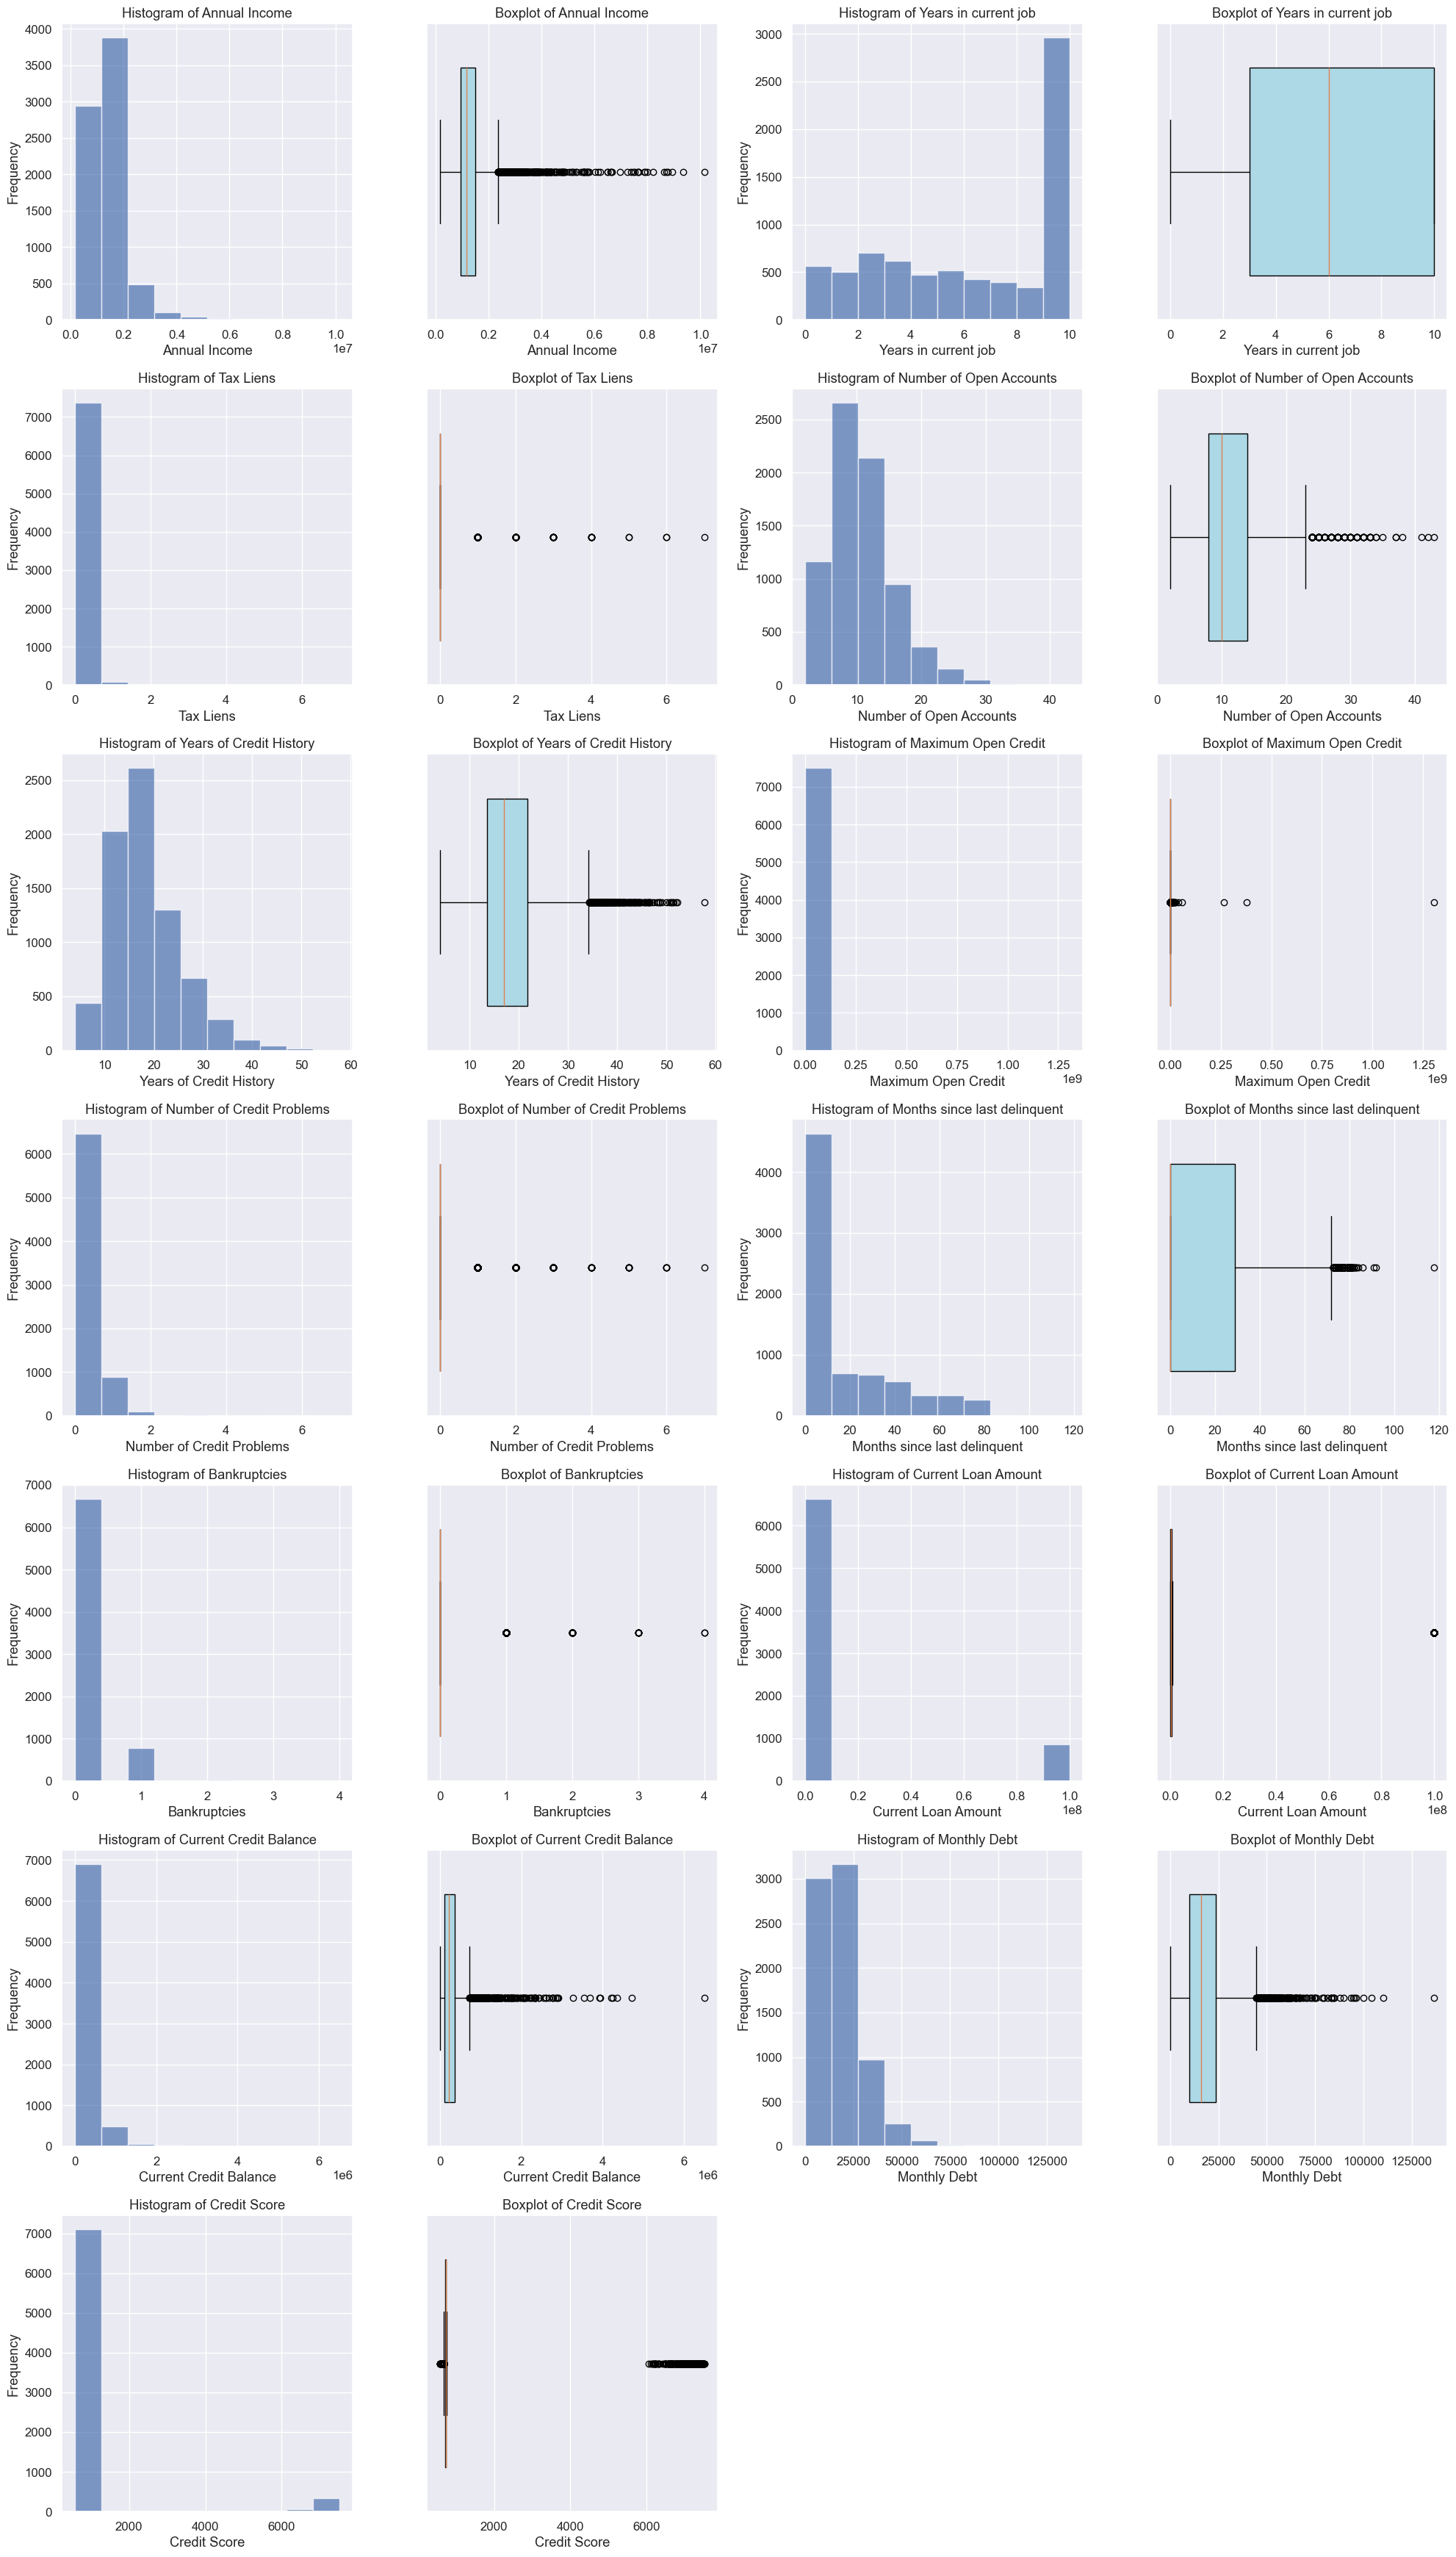

In [1629]:
# Функция вывода графиков гистограмм и боксплотов данных
def show_charts(df):

    df_train_numeric = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Credit Default'])

    # Вычисляем количество колонок
    num_cols = len(df_train_numeric.columns)

    # Вычисляем количество строк (каждый график боксплота будет на отдельной фигуре)
    num_rows = (num_cols + 1) // 2  # Чтобы уместить в 2 столбца, округляем в большую сторону

    # Создаем фигуры и оси для гистограмм и боксплотов
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    # Проходимся по каждой колонке и рисуем гистограмму и боксплот
    for i, column in enumerate(df_train_numeric.columns):
        row = i // 2
        col = (i % 2) * 2
        
        ax_hist = axes[row, col]
        ax_box = axes[row, col + 1]

        # Рисуем гистограмму
        ax_hist.hist(df_train_numeric[column], bins=10, alpha=0.7)
        ax_hist.set_title(f'Histogram of {column}')
        ax_hist.set_xlabel(column)
        ax_hist.set_ylabel('Frequency')

        # Рисуем боксплот
        ax_box.boxplot(df_train_numeric[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(f'Boxplot of {column}')
        ax_box.set_xlabel(column)
        ax_box.set_yticks([])  # Убираем метки на оси y для боксплота

    # Если количество колонок нечетное, удаляем последний пустой график
    if num_cols % 2 != 0:
        fig.delaxes(axes[-1, -1])
        fig.delaxes(axes[-1, -2])

    plt.tight_layout()
    plt.show()

show_charts(df_train)

**Annual Income**

Очень высокое максимальное значение: Максимальное значение годового дохода составляет 10,149,340.

Это значительно превышает значение 75%-квартиля и может быть потенциальным выбросом.

Большое стандартное отклонение: Стандартное отклонение в размере 756,755 также указывает

на значительный разброс данных вокруг среднего значения.

Это может указывать на наличие выбросов или широкое распределение данных.

In [1630]:
# Заменяем выбросы на квантили
big_to_q95(df_train, 'Annual Income')

**Tax Liens**

In [1631]:
df_train['Tax Liens'].value_counts()

Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: count, dtype: int64

Значения Tax Liens, превышающие 3, являются очень редкими и могут расцениваться как выбросы.

In [1632]:
# Заменяем значения, превышающие 3, на значение 3
df_train.loc[df_train['Tax Liens'] > 3, 'Tax Liens'] = 3

**Number of Open Accounts**

In [1633]:
# Заменяем выбросы на квантили
big_to_q95(df_train, 'Number of Open Accounts')

**Years of Credit History**

In [1634]:
# Заменяем выбросы на квантили
big_to_q95(df_train, 'Years of Credit History')

**Maximum Open Credit**

**Минимальное значение (min):** 0. Это может указывать на отсутствие информации о максимальном открытом кредите или на ошибку в данных. В реальных финансовых данных открытый кредит не может быть нулевым, так что такие записи потенциально аномальны.

**Максимальное значение (max):** 1304726000. Это очень большое значение, которое может быть выбросом или ошибочным значением. В реальных данных такая высокая сумма может быть необычной и требует дополнительной проверки.

In [1635]:
# Вычисляем квантили
q05 = df_train['Maximum Open Credit'].quantile(0.05)
q95 = df_train['Maximum Open Credit'].quantile(0.95)

df_train.loc[df_train['Maximum Open Credit'] < q05, 'Maximum Open Credit'] = q05
df_train.loc[df_train['Maximum Open Credit'] > q95, 'Maximum Open Credit'] = q95

**Number of Credit Problems**

In [1636]:
df_train['Number of Credit Problems'].value_counts()

Number of Credit Problems
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: count, dtype: int64

Значения Number of Credit Problems, превышающие 3, являются довольно редкими и могут восприниматься как выбросы.

In [1637]:
# Заменяем значения, превышающие 3, на значение 3
df_train.loc[df_train['Number of Credit Problems'] > 3, 'Number of Credit Problems'] = 3

**Bankruptcies**

In [1638]:
df_train['Bankruptcies'].value_counts()

Bankruptcies
0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: count, dtype: int64

Аналогично, начения Bankruptcies, превышающие 2, являются редкими и могут быть выбросами.

In [1639]:
# Заменяем значения, превышающие 2, на значение 2
df_train.loc[df_train['Bankruptcies'] > 2, 'Bankruptcies'] = 2

**Current Credit Balance**

**Разница между Current Loan Amount и Current Credit Balance** связана с контекстом финансовых обязательств и состояния долга. Вот как они различаются:

**Current Loan Amount (Текущая сумма кредита):** Это сумма денег, которую заемщик в настоящее время должен кредитору. То есть это общая сумма, которую заемщик взял в долг и которую ему предстоит вернуть, включая начисленные проценты.

**Current Credit Balance (Текущий кредитный баланс):** Это сумма денег, которую заемщик в настоящее время задолжал кредитору, за вычетом уже выплаченных сумм. То есть это остаток долга на данный момент времени.

**Что должно быть меньше, а что больше:**

Current Loan Amount (Текущая сумма кредита) должна быть больше Current Credit Balance (Текущий кредитный баланс). Это потому, что Current Loan Amount отражает общий объем кредита, который заемщик взял, включая неоплаченные проценты и основную сумму кредита.

Current Credit Balance (Текущий кредитный баланс) должен быть меньше Current Loan Amount (Текущая сумма кредита). Это показывает, сколько из этого общего долга заемщик уже выплатил, и сколько осталось погасить.

Например, если текущая сумма кредита (Current Loan Amount) составляет $10,000, а текущий кредитный баланс (Current Credit Balance) составляет $6,000, это означает, что заемщик взял в долг $10,000, но уже выплатил $4,000, и осталось еще $6,000 выплатить.

In [1640]:
(df_train['Current Loan Amount'] < df_train['Current Credit Balance']).sum()

2304

In [1641]:
# Заменяем значения, где Current Loan Amount < Current Credit Balance на значения Current Credit Balance
df_train.loc[df_train['Current Loan Amount'] < df_train['Current Credit Balance'], 'Current Loan Amount'] = df_train['Current Credit Balance']

In [1642]:
(df_train['Current Loan Amount'] < df_train['Current Credit Balance']).sum()

0

In [1643]:
big_to_q95(df_train, 'Current Credit Balance')

**Current Loan Amount**

In [1644]:
df_train['Current Loan Amount'].value_counts()

Current Loan Amount
99999999.0    870
218064.0        4
216106.0        4
219626.0        4
336116.0        4
             ... 
776622.0        1
449680.0        1
142802.0        1
552860.0        1
288192.0        1
Name: count, Length: 5995, dtype: int64

In [1645]:
# Вычисляем медиану столбца 'Current Loan Amount'
median_value = df_train['Current Loan Amount'].median()

# Обработаем аномальные значения 99999999.0, заменив их на среднее
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = median_value
big_to_q95(df_train, 'Current Loan Amount')

**Monthly Debt**

In [1646]:
# Слишком большие значения изменим на 95 квантиль
big_to_q95(df_train, 'Monthly Debt')

**Credit Score**

In [1647]:
# Вычисляем медиану столбца 'Credit Score'
median_value = df_train['Credit Score'].median()

# Обработаем аномальные значения, превышающие 2000, заменив их на среднее
df_train.loc[df_train['Credit Score'] > 2000, 'Credit Score'] = median_value

In [1648]:
# В распределении значений остается большой хвост слева, поэтому обработаем признак
small_to_q5(df_train, 'Credit Score')

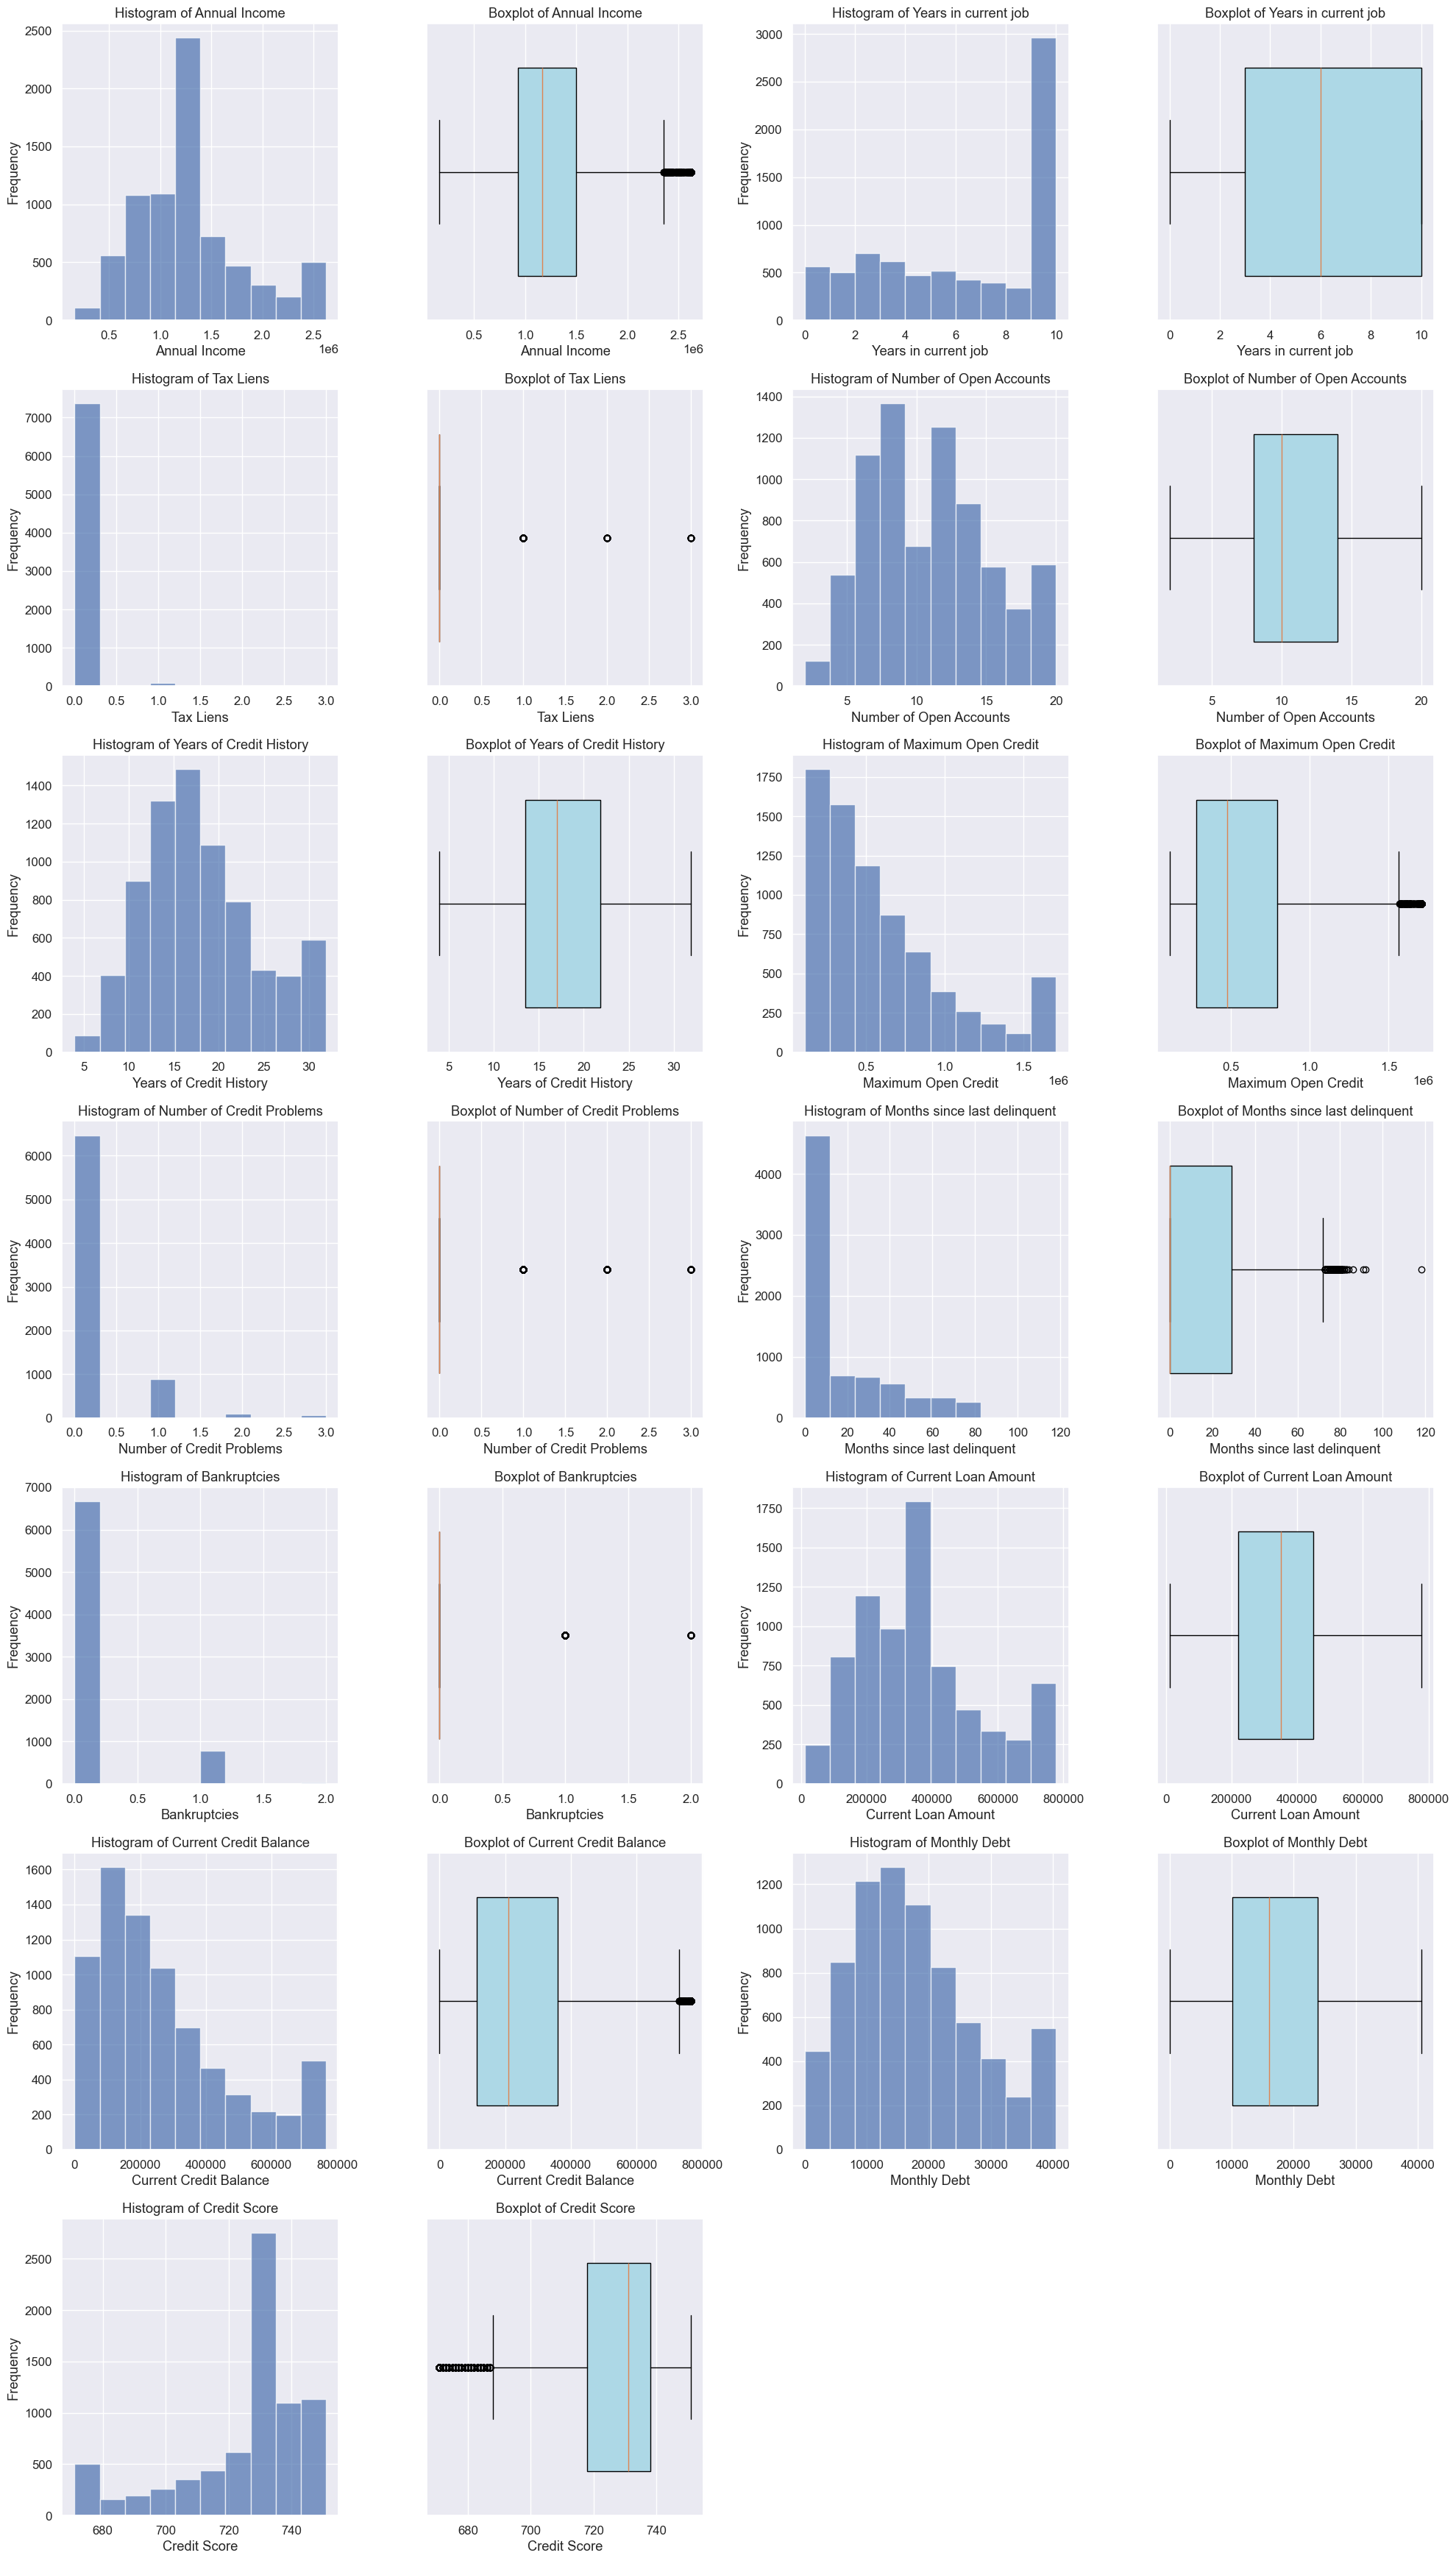

In [1649]:
show_charts(df_train)

In [1650]:
# Создадим класс для обработки датасета
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.numeric_columns = None
        self.numeric_data = None
        self.medians = None
        self.modes = None
        self.quantiles5 = None
        self.quantiles95 = None

    def fit(self, X):
        """Сохранение статистик"""
        self.numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.numeric_data = X[self.numeric_columns]
        self.medians = self.numeric_data.median()
        self.modes = self.numeric_data.mode()
        self.quantiles5 = self.numeric_data.quantile(.05)
        self.quantiles95 = self.numeric_data.quantile(.95)

    def transform(self, X):
        """Трансформация данных"""

        # Years in current job
        # Заменяем отсутствующие значения на моду
        nan_to_mode(X, 'Years in current job')
        # Словарь для замены текстовых значений на числовые
        years_mapping = {
            '< 1 year': 0,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10
        }
        # Применяем замену с помощью метода map
        X['Years in current job'] = X['Years in current job'].map(years_mapping)

        # Annual Income, Credit Score
        # Заполняем пропуски медианным значением
        nan_to_median(X, 'Annual Income')
        nan_to_median(X, 'Credit Score')

        # Tax Liens
        X.loc[X['Tax Liens'] > 3, 'Tax Liens'] = 3

        # Months since last delinquent, Bankruptcies
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(0)
        X['Bankruptcies'] = X['Bankruptcies'].fillna(0)

        # Annual Income
        big_to_q95(X, 'Annual Income')
        big_to_q95(X, 'Number of Open Accounts')
        big_to_q95(X, 'Years of Credit History')

        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] < self.quantiles5['Maximum Open Credit'], 'Maximum Open Credit'] = self.quantiles5['Maximum Open Credit']
        X.loc[X['Maximum Open Credit'] > self.quantiles95['Maximum Open Credit'], 'Maximum Open Credit'] = self.quantiles95['Maximum Open Credit']

        # Number of Credit Problems
        X.loc[X['Number of Credit Problems'] > 3, 'Number of Credit Problems'] = 3

        # Bankruptcies
        X.loc[X['Bankruptcies'] > 2, 'Bankruptcies'] = 2

        # Current Credit Balance, Current Loan Amount
        # Заменяем значения, где Current Loan Amount < Current Credit Balance на значения Current Credit Balance
        X.loc[X['Current Loan Amount'] < X['Current Credit Balance'], 'Current Loan Amount'] = X['Current Credit Balance']
        big_to_q95(X, 'Current Credit Balance')
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        big_to_q95(X, 'Current Loan Amount')

        # Monthly Debt
        big_to_q95(X, 'Monthly Debt')

        # Credit Score
        X.loc[X['Credit Score'] > 2000, 'Credit Score'] = self.medians['Credit Score']
        small_to_q5(X, 'Credit Score')

        return X

### Построение новых признаков<a class="anchor" id="new_features"></a>

In [1651]:
df_train.select_dtypes(include=['object'])

,Home Ownership,Purpose,Term
0,Own Home,debt consolidation,Short Term
1,Own Home,debt consolidation,Long Term
2,Home Mortgage,debt consolidation,Short Term
3,Own Home,debt consolidation,Short Term
4,Rent,debt consolidation,Short Term
...,...,...,...
7495,Rent,other,Short Term
7496,Home Mortgage,debt consolidation,Long Term
7497,Rent,buy a car,Short Term
7498,Home Mortgage,debt consolidation,Short Term


### Dummies

In [1652]:
df_train['Home Ownership'].value_counts()

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64

In [1653]:
pd.get_dummies(df_train['Home Ownership'], dtype='int64')

,Have Mortgage,Home Mortgage,Own Home,Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
7495,0,0,0,1
7496,0,1,0,0
7497,0,0,0,1
7498,0,1,0,0


In [1654]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'], dtype='int64')], axis=1)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,Short Term,349701.0,47386.0,7914.0,749.0,0,0,0,1,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,Long Term,394972.0,394972.0,18373.0,737.0,1,0,0,1,0
2,Home Mortgage,751412.0,8,0.0,11.0,31.9,1182434.0,0.0,0.0,0.0,...,Short Term,349701.0,308389.0,13651.0,742.0,0,0,1,0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0,1,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,0,1


In [1655]:
df_train['Purpose'].value_counts()

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64

In [1656]:
pd.get_dummies(df_train['Purpose'], dtype='int64')

,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7496,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7497,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7498,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [1657]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Purpose'], dtype='int64')], axis=1)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8,0.0,11.0,31.9,1182434.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1658]:
df_train['Term'].value_counts()

Term
Short Term    5556
Long Term     1944
Name: count, dtype: int64

In [1659]:
# Категориальные признаки ниже переведем в бинарные (их значения - Short Term, Long Term)
binary_to_numbers = { 'Short Term': 0, 'Long Term': 1 }

df_train['Term'] = df_train['Term'].map(binary_to_numbers)

In [1660]:
df_train['Term'].value_counts()

Term
0    5556
1    1944
Name: count, dtype: int64

**Дополнительные признаки, которые можно создать из имеющегося набора данных:**

**Loan-to-Income Ratio** (отношение текущей суммы кредита к годовому доходу): Этот признак может помочь оценить финансовую нагрузку заемщика. Вычисляется как Current Loan Amount / Annual Income.

**Credit Utilization Ratio** (коэффициент использования кредита): Этот признак оценивает, какую часть открытого кредита использует заемщик от максимально доступного. Вычисляется как Current Credit Balance / Maximum Open Credit.

**Delinquency Ratio** (коэффициент просрочек): Этот признак оценивает частоту просрочек платежей. Вычисляется как Months since last delinquent / Years of Credit History.

**Debt-to-Income Ratio** (отношение ежемесячного долга к годовому доходу): Этот признак показывает, какая часть дохода уходит на выплату долгов. Вычисляется как Monthly Debt * 12 / Annual Income.

Эти дополнительные признаки могут быть полезны для улучшения модели предсказания дефолта кредита, так как они предоставляют дополнительную информацию о финансовом состоянии заемщика и его кредитной истории.

In [1661]:
df_train['Loan-to-Income Ratio'] = df_train['Current Loan Amount'] / df_train['Annual Income']
df_train['Credit Utilization Ratio'] = df_train['Current Credit Balance'] / df_train['Maximum Open Credit']
df_train['Delinquency Ratio'] = df_train['Months since last delinquent'] / df_train['Years of Credit History']
df_train['Debt-to-Income Ratio'] = df_train['Monthly Debt']  * 12 / df_train['Annual Income']
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,other,renewable energy,small business,take a trip,vacation,wedding,Loan-to-Income Ratio,Credit Utilization Ratio,Delinquency Ratio,Debt-to-Income Ratio
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0.725390,0.069080,0.0,0.196993
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.385156,0.334232,0.0,0.214996
2,Home Mortgage,751412.0,8,0.0,11.0,31.9,1182434.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.465392,0.260809,0.0,0.218006
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0.150790,0.650305,0.0,0.168999
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.162110,0.241836,0.0,0.110993


In [1662]:
# Класс для генерации новых признаков
class FeatureGenerator():
    """Генерация новых фич"""

    def __init__(self):
        self.binary_to_numbers = None
        self.home_ownership_dummies = None
        self.purpose_dummies = None
        self.loan_to_income_ratio = None
        self.credit_utilization_ratio = None
        self.delinquency_ratio = None
        self.debt_to_income_ratio = None

    def fit(self, X):

        X = X.copy()

        # Binary features
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

        self.home_ownership_dummies = pd.get_dummies(X['Home Ownership'], dtype='int64')
        self.purpose_dummies = pd.get_dummies(X['Purpose'], dtype='int64')

        # New features
        self.loan_to_income_ratio = X['Current Loan Amount'] / X['Annual Income']
        self.credit_utilization_ratio = X['Current Credit Balance'] / X['Maximum Open Credit']
        self.delinquency_ratio = X['Months since last delinquent'] / X['Years of Credit History']
        self.debt_to_income_ratio = X['Monthly Debt']  * 12 / X['Annual Income']

    def transform(self, X):

        # Binary features
        X['Term'] = X['Term'].map(self.binary_to_numbers)

        X = pd.concat([X, self.home_ownership_dummies], axis=1)
        X = pd.concat([X, self.purpose_dummies], axis=1)

        # New features
        X['Loan-to-Income Ratio'] = self.loan_to_income_ratio
        X['Credit Utilization Ratio'] = self.credit_utilization_ratio
        X['Delinquency Ratio'] = self.delinquency_ratio
        X['Debt-to-Income Ratio'] = self.debt_to_income_ratio
        
        return X

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [1663]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [1664]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,other,renewable energy,small business,take a trip,vacation,wedding,Loan-to-Income Ratio,Credit Utilization Ratio,Delinquency Ratio,Debt-to-Income Ratio
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0.725390,0.069080,0.0,0.196993
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.385156,0.334232,0.0,0.214996
2,Home Mortgage,751412.0,8,0.0,11.0,31.9,1182434.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.465392,0.260809,0.0,0.218006
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0.150790,0.650305,0.0,0.168999
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.162110,0.241836,0.0,0.110993


In [1665]:
BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME, 'Home Ownership', 'Purpose']).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'Home Ownership', 'Purpose'] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [1666]:
NUM_FEATURE_NAMES = [
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Bankruptcies',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
    'Loan-to-Income Ratio',
    'Credit Utilization Ratio',
    'Delinquency Ratio',
    'Debt-to-Income Ratio'
]

SELECTED_FEATURE_NAMES = BASE_FEATURE_NAMES + NEW_FEATURE_NAMES

### Нормализация данных<a class="anchor" id="normalization"></a>

In [1667]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [1668]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [1669]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [1670]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

Credit Default
0    3771
1    2958
Name: count, dtype: int64

In [1671]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [1672]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [1673]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [1674]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      3771
           1       0.61      0.47      0.53      2958

    accuracy                           0.64      6729
   macro avg       0.63      0.62      0.62      6729
weighted avg       0.63      0.64      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1616
           1       0.42      0.45      0.44       634

    accuracy                           0.67      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.68      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1222  394
1                348  286


**k ближайших соседей**

In [1675]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3771
           1       0.74      0.81      0.78      2958

    accuracy                           0.79      6729
   macro avg       0.79      0.80      0.79      6729
weighted avg       0.80      0.79      0.79      6729

TEST

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1616
           1       0.35      0.44      0.39       634

    accuracy                           0.61      2250
   macro avg       0.55      0.56      0.55      2250
weighted avg       0.64      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1081  535
1                352  282


**Бустинговые алгоритмы**

*XGBoost*

In [1676]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3771
           1       0.99      0.99      0.99      2958

    accuracy                           0.99      6729
   macro avg       0.99      0.99      0.99      6729
weighted avg       0.99      0.99      0.99      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.50      0.42      0.46       634

    accuracy                           0.72      2250
   macro avg       0.64      0.63      0.63      2250
weighted avg       0.70      0.72      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1344  272
1                366  268


*LightGBM*

In [1677]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2958, number of negative: 3771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 6729, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439590 -> initscore=-0.242827
[LightGBM] [Info] Start training from score -0.242827
TRAIN

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3771
           1       0.95      0.91      0.93      2958

    accuracy                           0.94      6729
   macro avg       0.94      0.93      0.94      6729
weighted avg       0.94      0.94      0.94      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.83 

*CatBoost*

In [1678]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3771
           1       0.93      0.89      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.92      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1616
           1       0.53      0.47      0.50       634

    accuracy                           0.73      2250
   macro avg       0.66      0.65      0.66      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1345  271
1                333  301


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [1679]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [1680]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [1681]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [1682]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: total: 30.6 s
Wall time: 2min 22s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001591B3AC810>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [1683]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 5}

In [1684]:
best_n_estimators = rs.best_params_['n_estimators']

In [1685]:
best_max_depth = rs.best_params_['max_depth']

In [1686]:
rs.best_score_

0.5372416976481741

**Обучение и оценка финальной модели**

In [1687]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3771
           1       0.88      0.83      0.85      2958

    accuracy                           0.87      6729
   macro avg       0.88      0.87      0.87      6729
weighted avg       0.87      0.87      0.87      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.51      0.50      0.51       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1317  299
1                318  316
CPU times: total: 21.9 s
Wall time: 6.87 s


## Улучшение полученной модели

In [1688]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [1689]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [1690]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances_ = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_ = feature_importances_.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances_) * 0.355))
    
    sns.barplot(x=feature_importances_['importance'], y=feature_importances_['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances_['feature'][:get_top].tolist()

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [1691]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

In [1692]:
X = df.drop(columns=[TARGET_NAME, 'Home Ownership', 'Purpose'])
y = df[TARGET_NAME]

X_train = df_train.drop(columns=TARGET_NAME)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=TARGET_NAME)
y_test = df_test[TARGET_NAME]

### Модель, полученная на предыдущем шаге

In [1693]:
final_model = catb.CatBoostClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3771
           1       0.88      0.83      0.85      2958

    accuracy                           0.87      6729
   macro avg       0.88      0.87      0.87      6729
weighted avg       0.87      0.87      0.87      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.51      0.50      0.51       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1317  299
1                318  316


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [1694]:
final_model = catb.CatBoostClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3771
           1       0.89      0.85      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.88      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1616
           1       0.52      0.49      0.50       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1330  286
1                324  310


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [1695]:
final_model = catb.CatBoostClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

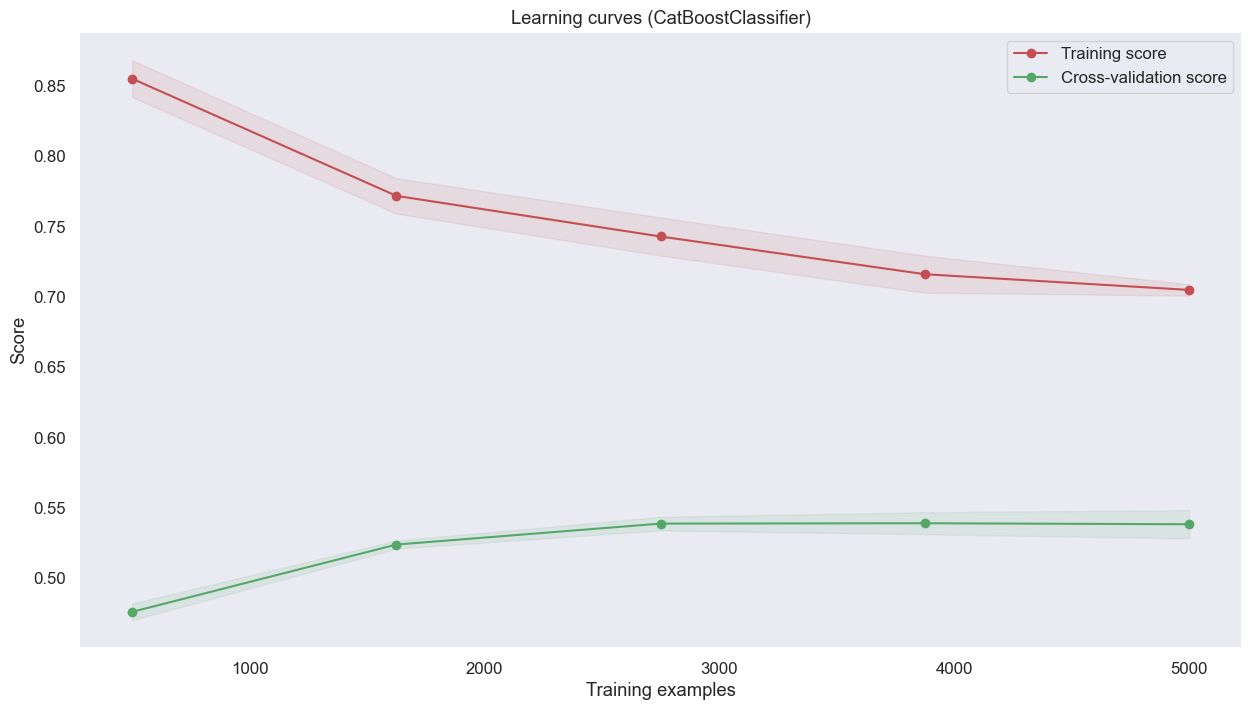

In [1696]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

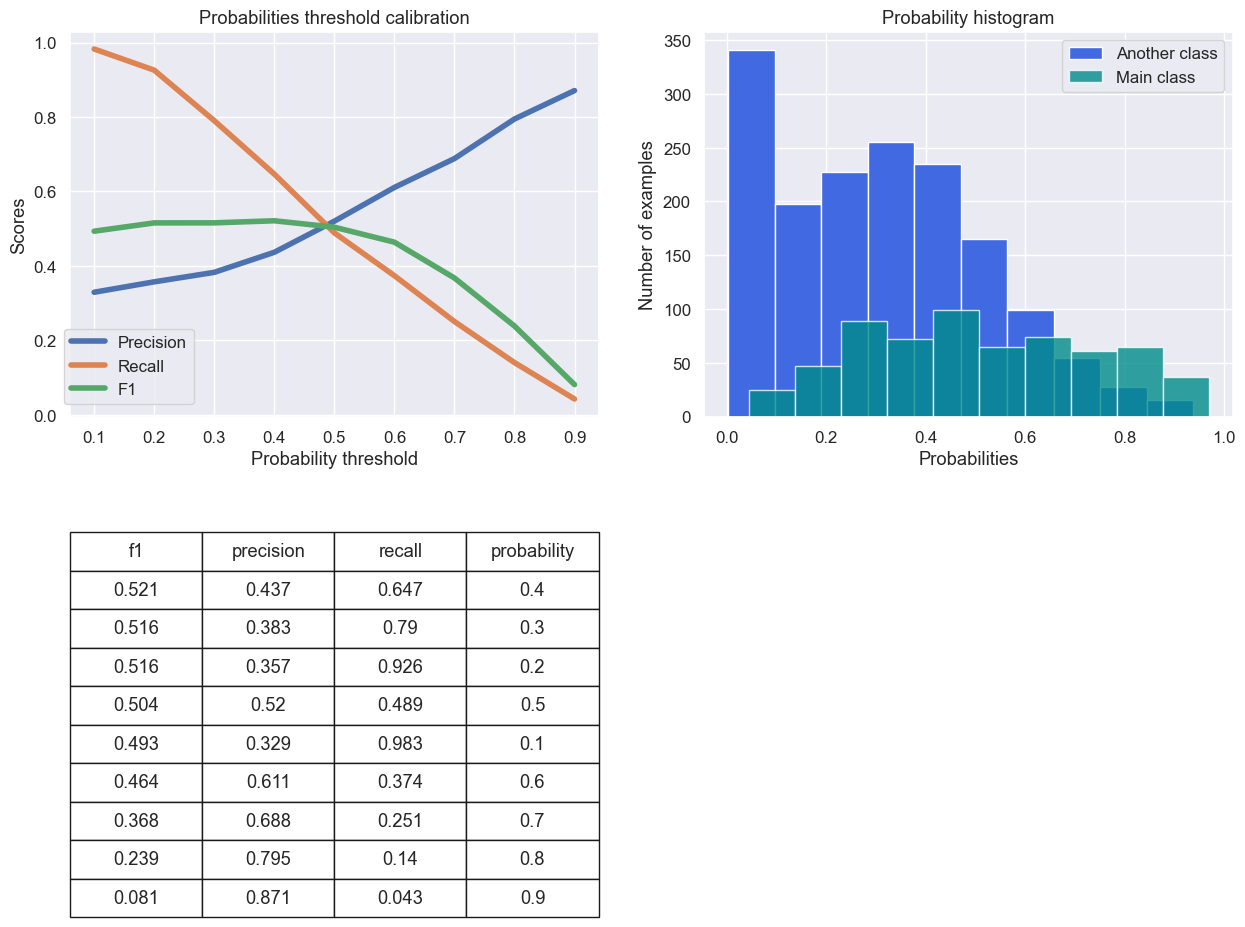

In [1697]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

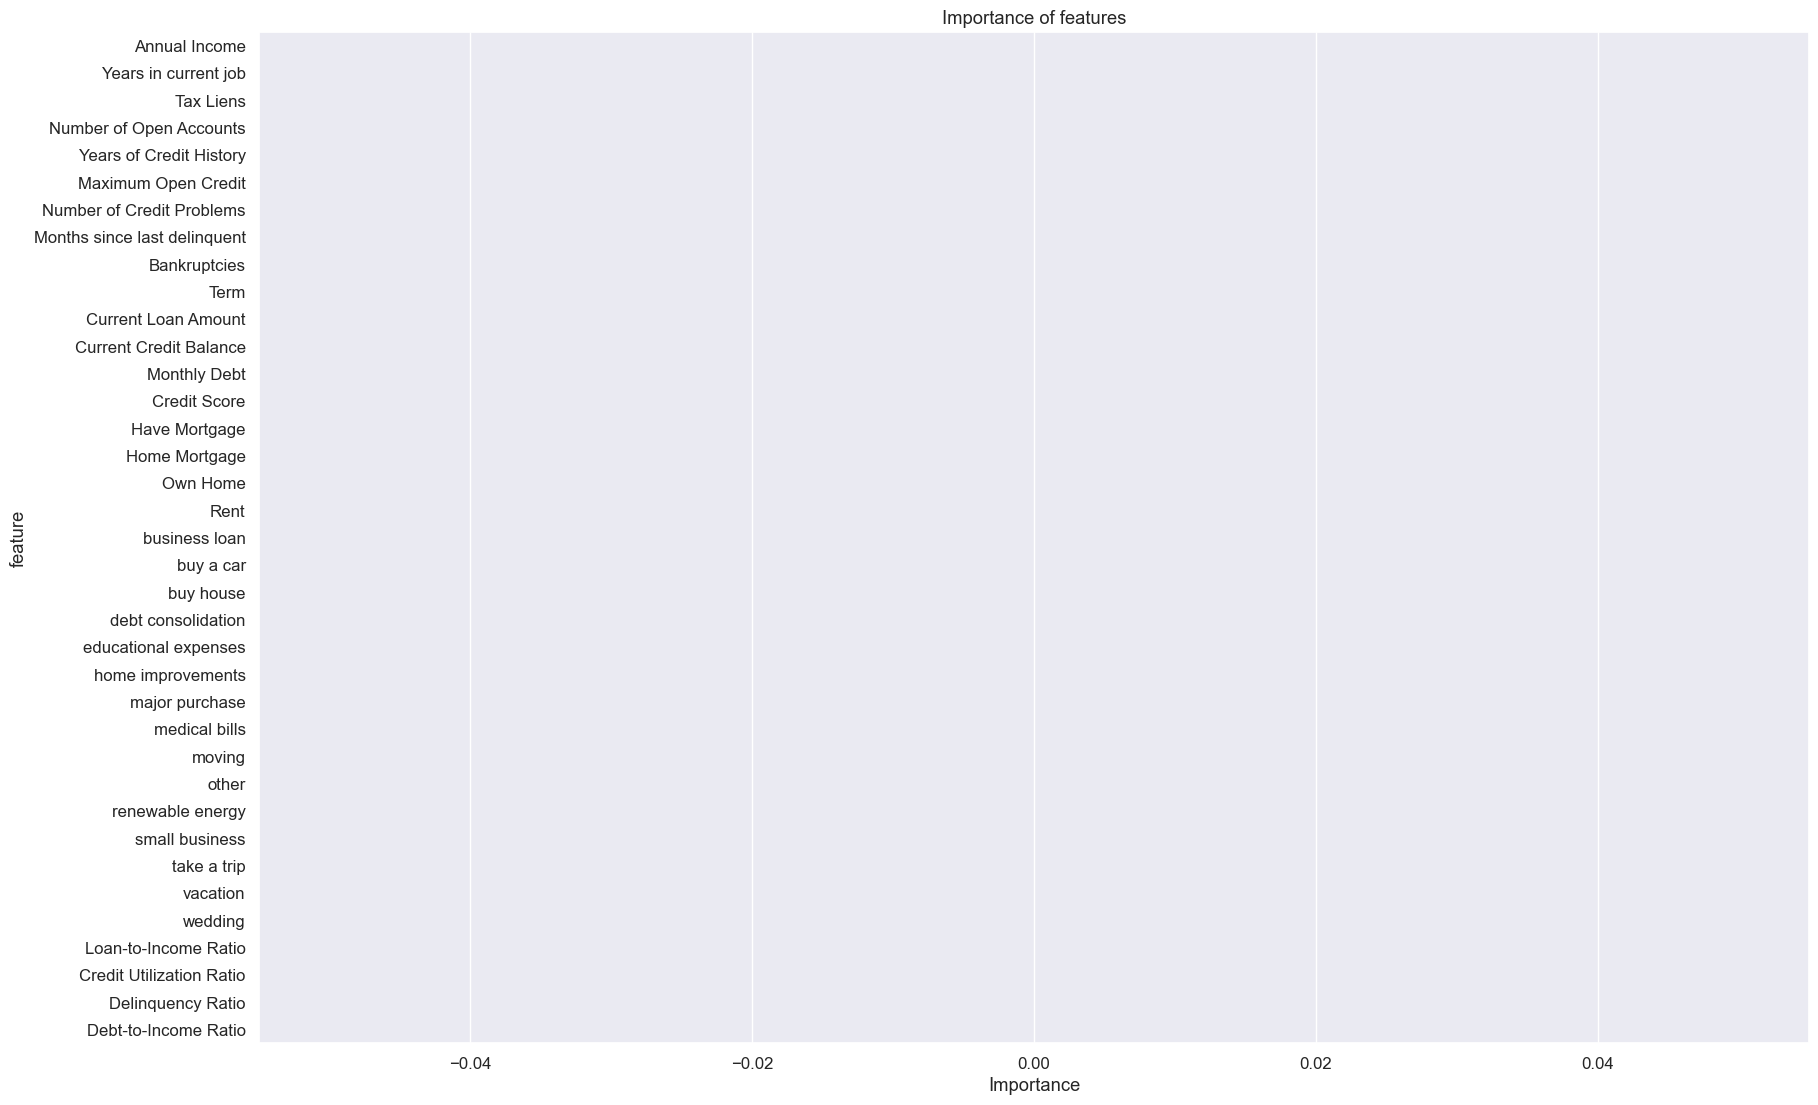

In [1698]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [1699]:
important_features_top

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Have Mortgage']

### Финальная модель<a class="anchor" id="final_model"></a>

In [1700]:
final_model = catb.CatBoostClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, l2_leaf_reg=100,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3771
           1       0.83      0.77      0.80      2958

    accuracy                           0.83      6729
   macro avg       0.83      0.82      0.83      6729
weighted avg       0.83      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.52      0.52      0.52       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1317  299
1                306  328


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [1701]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)